<a href="https://colab.research.google.com/github/serdarbozoglan/01_Computer_Vision/blob/master/CIFAR10_SqueezeNet_VGG16_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from tensorflow.keras.layers import Input, Dense, Conv2D
from tensorflow.keras.layers import MaxPool2D, Dropout, Activation
from tensorflow.keras.layers import concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import optimizers
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics
from PIL import Image



%matplotlib inline
%config InlineBackend.figure_format='retina'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Turn off scientific notation
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

RANDOM_SEED =4299
np.random.seed(RANDOM_SEED)
#torch.manual_seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [0]:
(train_data, train_label), (test_data, test_label) = cifar10.load_data()

In [81]:
train_data.shape
test_data.shape
train_label.shape
test_label.shape

(50000, 32, 32, 3)

(10000, 32, 32, 3)

(50000, 1)

(10000, 1)

In [0]:
def plot_10_by_10_images(images):

    fig = plt.figure(figsize=(10,10))

    for x in range(10):
        for y in range(10):
            ax = fig.add_subplot(10, 10, 10 * y + x + 1)
            plt.imshow(images[10*y+x])
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
    plt.show()

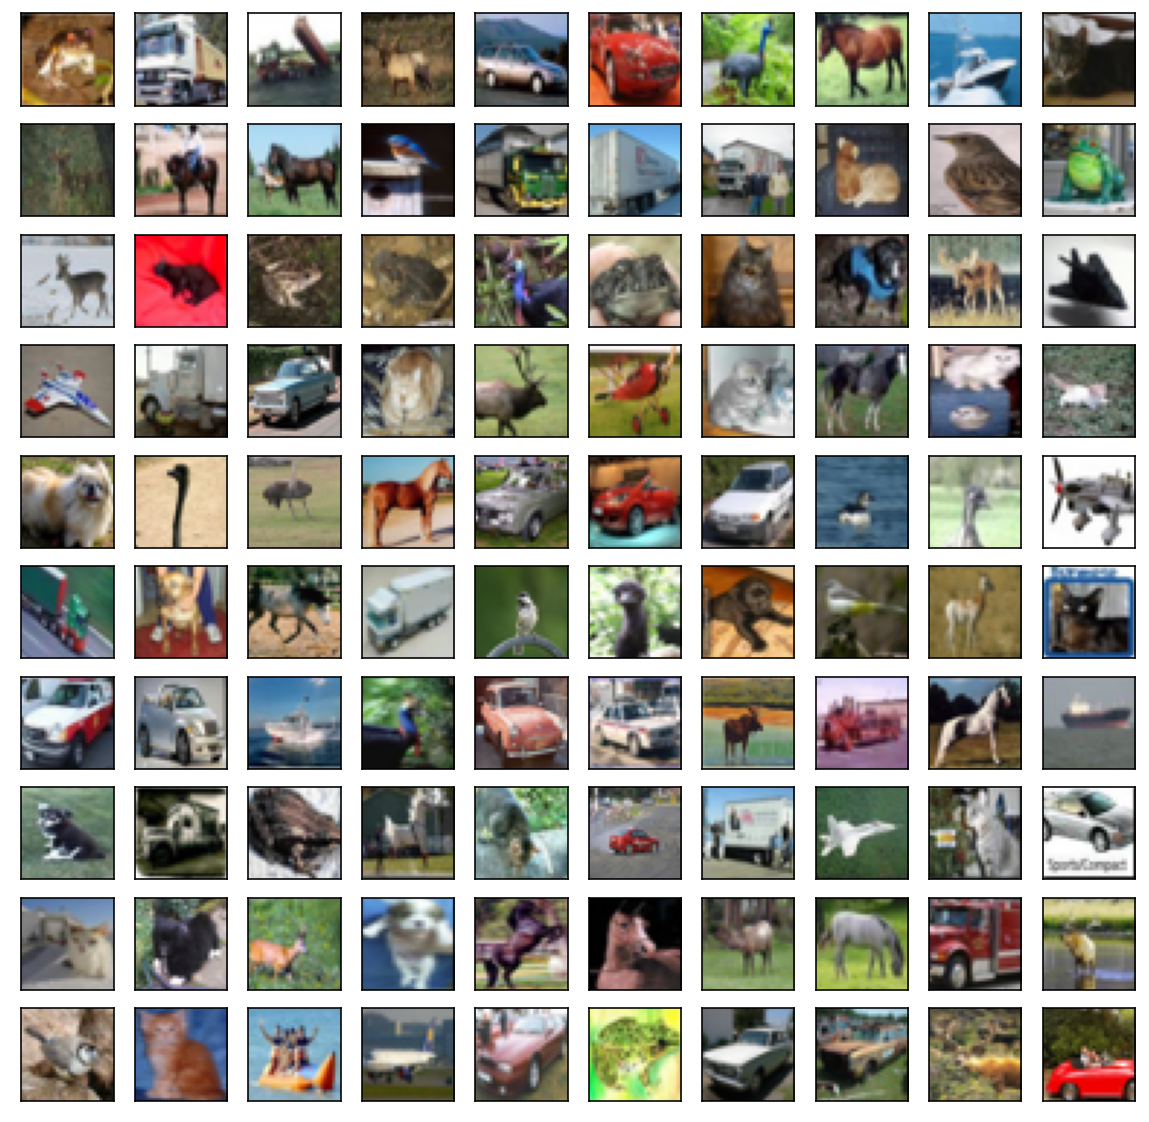

In [83]:
plot_10_by_10_images(train_data[:100])

### SqueezeNet

In [0]:
def fire_module(x, fire_id, squeeze=16, expand=64):
    sq1x1 = 'squeeze1x1'
    exp1x1 = 'expand1x1'
    exp3x3 = "expand3x3"
    relu = "relu_"
    s_id = 'fire' + str(fire_id) + '/'

    # Squeeze Layer
    x = Conv2D(squeeze, (1,1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name = s_id + relu + sq1x1)(x)

    # Expand Layer 1x1 filtres 
    left = Conv2D(expand, (1,1), padding='valid', name = s_id + exp1x1)(x)
    left = Activation('relu', name= s_id + relu + exp1x1)(left)

    # Expand Layer 3x3 filtres 
    right = Conv2D(expand, (3,3), padding='same', name = s_id + exp3x3)(x)
    right = Activation('relu', name = s_id + relu + exp3x3)(right)

    # Concatenate outputs
    x = concatenate([left, right], axis=3, name = s_id + 'concat')

    return x


### Implementation SqueezeNet

In [0]:
def SqueezeNet(input_shape=(32,32,3), classes=10):

    img_input = Input(shape=input_shape)

    x = Conv2D(64, (3, 3), strides =(2,2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPool2D(pool_size=(3,3), strides=(2,2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = Dropout(0.5, name='drop9')(x)

    x = Conv2D(classes, (1,1), padding='valid', name='conv10')(x)
    x = Activation('relu', name='relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    out = Activation('softmax', name='loss')(x)

    model = Model(inputs=img_input, outputs=out, name='squeezenet')

    return model


In [18]:
squeeze_net = SqueezeNet()
squeeze_net.summary()

Model: "squeezenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 15, 15, 64)   1792        input_2[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 15, 15, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
fire2/squeeze1x1 (Conv2D)       (None, 15, 15, 16)   1040        relu_conv1[0][0]                 
_________________________________________________________________________________________

### Image Preprocessing & Augmentation

In [0]:
train_datagen = ImageDataGenerator(
                rescale = 1. / 255,
                shear_range=0.1,
                zoom_range=0.1,
                horizontal_flip=True)

# No augmentation for test data but preprocessing
test_datagen = ImageDataGenerator(rescale= 1. /255)


### OHE Target Vector

In [0]:
X_train = train_data.copy()
X_test = test_data.copy()
y_train = to_categorical(train_label, num_classes=10)
y_test = to_categorical(test_label, num_classes=10)

### Data Generator

In [0]:
train_generator = train_datagen.flow(x=X_train, y=y_train, batch_size=32, shuffle=True)
test_generator = test_datagen.flow(x=X_test, y=y_test, batch_size=32, shuffle=True)

### Compile Model

In [0]:
def compile_model(model, optimizer='Adam', learning_rate=0.001):

    # loss
    loss = categorical_crossentropy

    # optimizer
    if optimizer =='Adam':
        optimizer = optimizers.Adam(lr=learning_rate)
    if optimizer == 'RMSProp': 
        optimizer = optimizers.RMSprop(lr=0.001)

    # metrics
    # top_k_categorical_accuracy returns top 5 predictions
    metric = [metrics.categorical_accuracy, metrics.top_k_categorical_accuracy]

    # compile model
    model.compile(optimizer, loss, metric)

    return model

In [0]:
squeeze_net = compile_model(squeeze_net)

In [20]:
history = squeeze_net.fit_generator(train_generator,
                        steps_per_epoch=400,
                        epochs=55,
                        validation_data=test_generator,
                        validation_steps=200)

Epoch 1/55
400/400 [==============================] - 14s 34ms/step - loss: 2.1128 - categorical_accuracy: 0.1964 - top_k_categorical_accuracy: 0.7191 - val_loss: 1.9271 - val_categorical_accuracy: 0.2598 - val_top_k_categorical_accuracy: 0.8289
Epoch 2/55
400/400 [==============================] - 13s 33ms/step - loss: 1.8978 - categorical_accuracy: 0.2837 - top_k_categorical_accuracy: 0.8253 - val_loss: 1.7653 - val_categorical_accuracy: 0.3430 - val_top_k_categorical_accuracy: 0.8526
Epoch 3/55
400/400 [==============================] - 13s 33ms/step - loss: 1.7570 - categorical_accuracy: 0.3346 - top_k_categorical_accuracy: 0.8618 - val_loss: 1.6340 - val_categorical_accuracy: 0.3824 - val_top_k_categorical_accuracy: 0.8960
Epoch 4/55
400/400 [==============================] - 13s 33ms/step - loss: 1.6373 - categorical_accuracy: 0.3934 - top_k_categorical_accuracy: 0.8902 - val_loss: 1.5498 - val_categorical_accuracy: 0.4242 - val_top_k_categorical_accuracy: 0.9102
Epoch 5/55
400/4

In [0]:
def plot_accuracy_and_loss(history, title):

    plt.figure(1, figsize=(15,10))

    # Accuracy
    plt.subplot(221)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title(title+' Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')

    # Loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title+' Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')

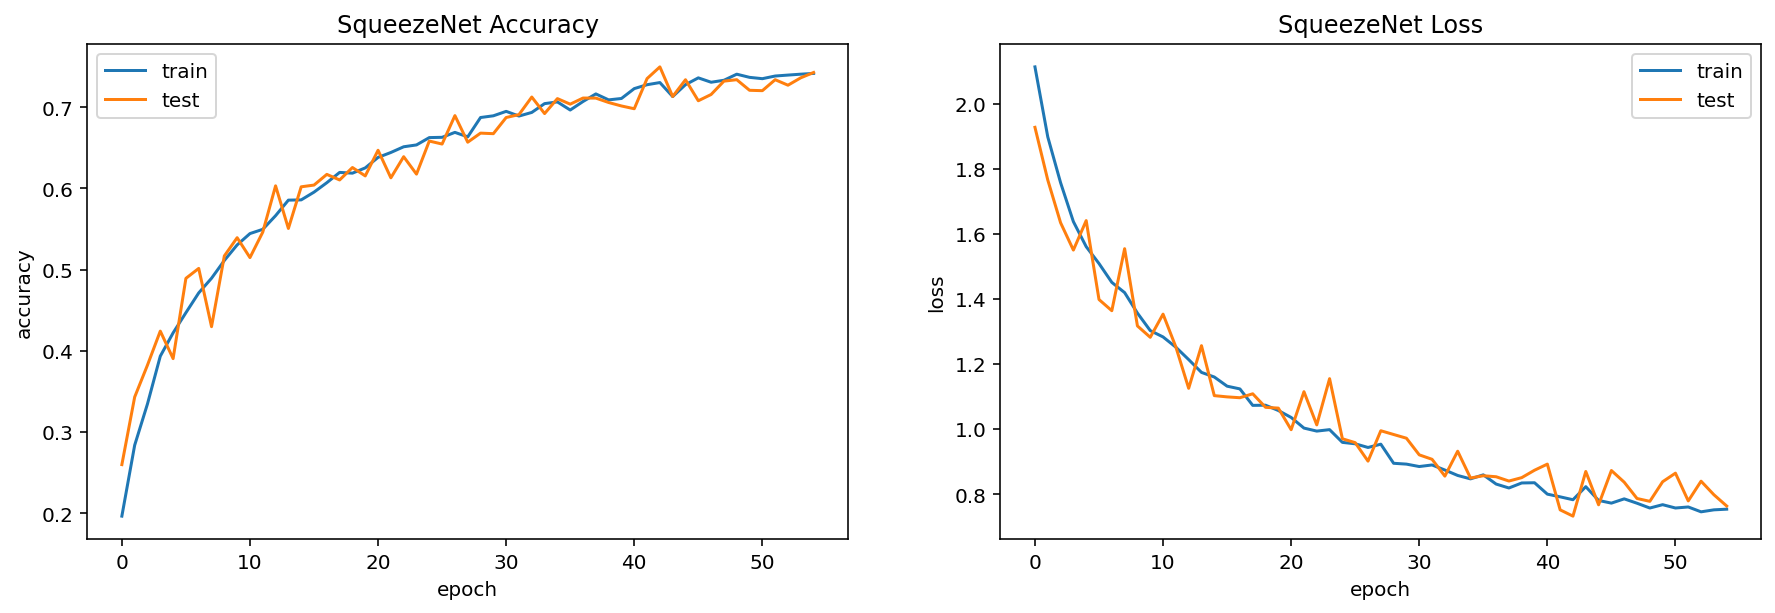

In [26]:
plot_accuracy_and_loss(history)

### Using VGG16

In [0]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
from tensorflow.keras.models import Model


IMAGE_SIZE = [32,32]
# add preprocessing layer to the front of VGG
# [3] is for color dimension
# to exclude the last layer, we say include_top=False, wewill use our own classifier
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# NOT to train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [0]:
# our layer starts here
x = Flatten()(vgg.output)
prediction = Dense(10, activation='softmax')(x)

In [75]:
# create a model
model_vgg16 = Model(inputs=vgg.input, outputs=prediction)

# model summary
model_vgg16.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [0]:
model_vgg16 = compile_model(model_vgg16)

In [77]:
history_vgg16 = model2.fit_generator(train_generator,
                        steps_per_epoch=400,
                        epochs=55,
                        validation_data=test_generator,
                        validation_steps=200)

Epoch 1/55
400/400 [==============================] - 16s 41ms/step - loss: 1.2326 - categorical_accuracy: 0.5815 - top_k_categorical_accuracy: 0.9474 - val_loss: 1.2618 - val_categorical_accuracy: 0.5705 - val_top_k_categorical_accuracy: 0.9444
Epoch 2/55
400/400 [==============================] - 16s 39ms/step - loss: 1.2113 - categorical_accuracy: 0.5878 - top_k_categorical_accuracy: 0.9469 - val_loss: 1.2391 - val_categorical_accuracy: 0.5756 - val_top_k_categorical_accuracy: 0.9445
Epoch 3/55
400/400 [==============================] - 15s 39ms/step - loss: 1.2374 - categorical_accuracy: 0.5829 - top_k_categorical_accuracy: 0.9487 - val_loss: 1.2818 - val_categorical_accuracy: 0.5592 - val_top_k_categorical_accuracy: 0.9461
Epoch 4/55
400/400 [==============================] - 16s 39ms/step - loss: 1.1979 - categorical_accuracy: 0.5898 - top_k_categorical_accuracy: 0.9517 - val_loss: 1.2336 - val_categorical_accuracy: 0.5808 - val_top_k_categorical_accuracy: 0.9442
Epoch 5/55
400/4

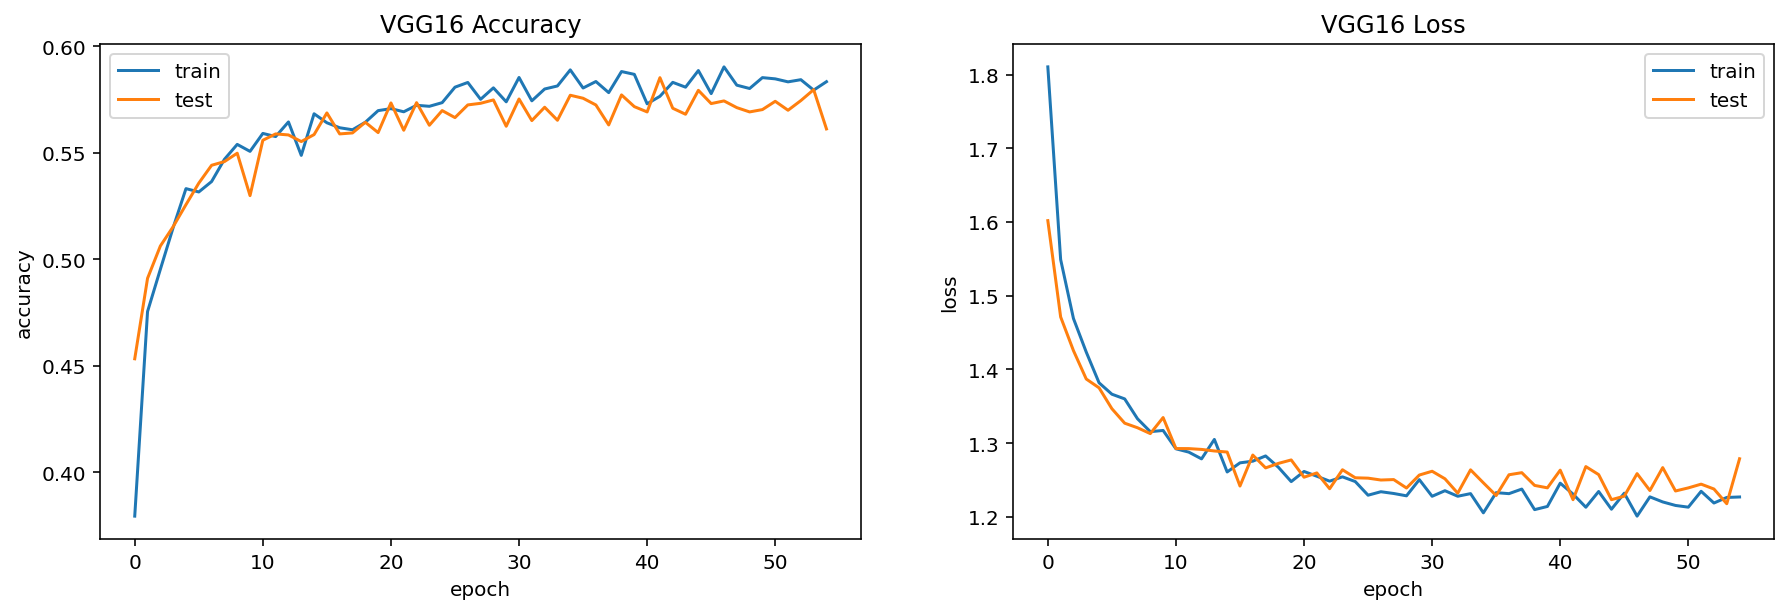

In [44]:
plot_accuracy_and_loss(history2, 'VGG16')

## Using ResNet

In [0]:
from tensorflow.keras.applications import resnet50
#Load the ResNet50 model
# add preprocessing layer to the front of VGG
# [3] is for color dimension
# to exclude the last layer, we say include_top=False, wewill use our own classifier
resnet = resnet50.ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# NOT to train exisitng weights
for layer in resnet.layers:
    layer.trainable = False

In [0]:
# our layer starts here
x = Flatten()(resnet.output)
prediction = Dense(10, activation='softmax')(x)

In [55]:
# create a model
resnet_model = Model(inputs=resnet.input, outputs=prediction)

# model summary
resnet_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [0]:
resnet_model = compile_model(resnet_model)

In [57]:
history_resnet= resnet_model.fit_generator(train_generator,
                        steps_per_epoch=400,
                        epochs=55,
                        validation_data=test_generator,
                        validation_steps=200)

Epoch 1/55
400/400 [==============================] - 20s 50ms/step - loss: 2.2699 - categorical_accuracy: 0.1591 - top_k_categorical_accuracy: 0.6200 - val_loss: 2.1486 - val_categorical_accuracy: 0.2415 - val_top_k_categorical_accuracy: 0.6975
Epoch 2/55
400/400 [==============================] - 19s 47ms/step - loss: 2.1356 - categorical_accuracy: 0.2093 - top_k_categorical_accuracy: 0.7220 - val_loss: 2.0946 - val_categorical_accuracy: 0.2165 - val_top_k_categorical_accuracy: 0.7469
Epoch 3/55
400/400 [==============================] - 19s 47ms/step - loss: 2.0763 - categorical_accuracy: 0.2353 - top_k_categorical_accuracy: 0.7548 - val_loss: 2.0712 - val_categorical_accuracy: 0.2261 - val_top_k_categorical_accuracy: 0.7741
Epoch 4/55
400/400 [==============================] - 19s 47ms/step - loss: 2.0338 - categorical_accuracy: 0.2511 - top_k_categorical_accuracy: 0.7760 - val_loss: 1.9310 - val_categorical_accuracy: 0.2987 - val_top_k_categorical_accuracy: 0.8192
Epoch 5/55
400/4

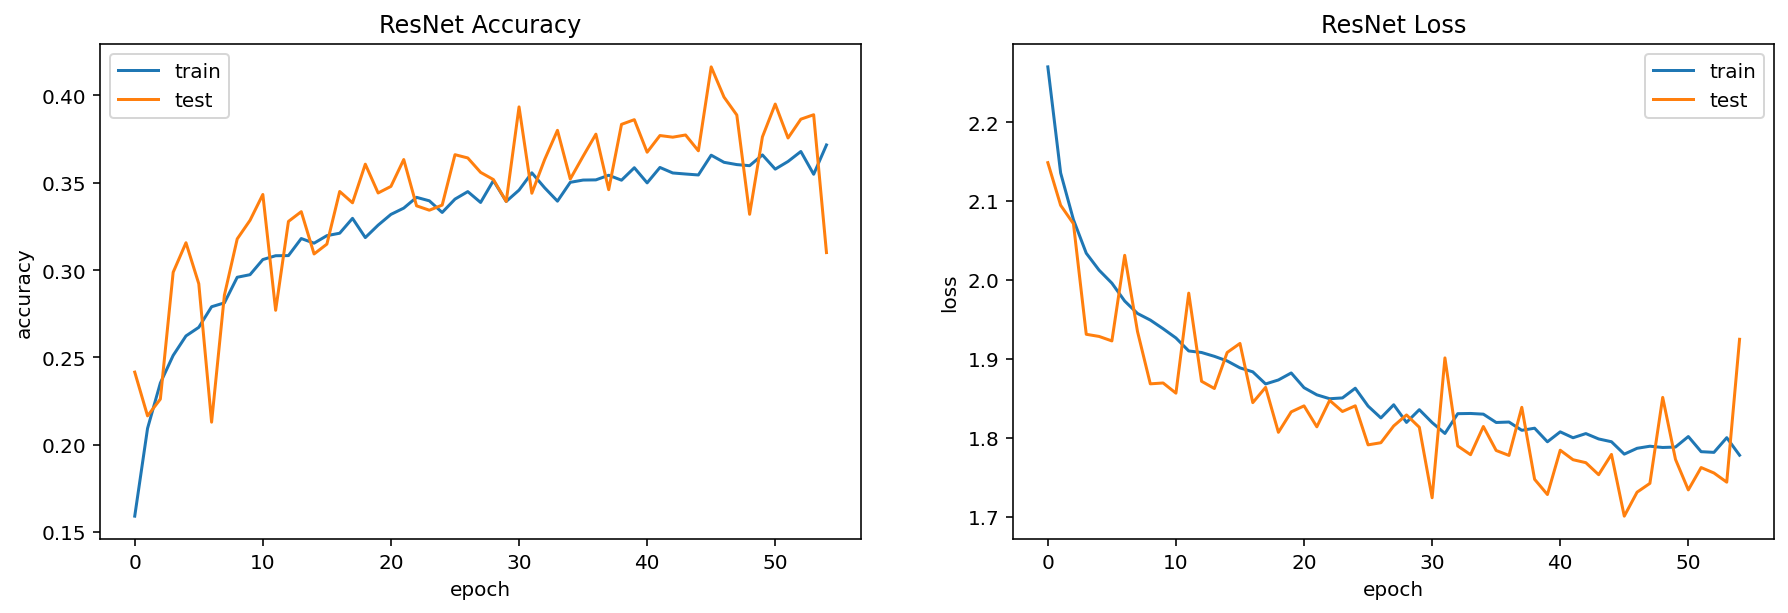

In [59]:
plot_accuracy_and_loss(history_resnet, 'ResNet')